In [1]:
## notebook to test AdvectParcel class woth GOES data, need to vectorize operations to speed up

#### will need to edit this if the year changes during the clouds tracking####

import trackerlib
from csat2 import misc, ECMWF, GOES
import datetime
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import time
import xarray as xr

In [2]:
#select the initial time and location of the air parcel

year, doy, hour = 2020, 65, 00 # Year, day of year, hour of day
initial_lon = -130.5406  # Longitude of the fixed point
initial_lat = 35.6665  # Latitude of the fixed point
init_time = misc.time.ydh_to_datetime(year, doy, hour)
time_step = datetime.timedelta(hours=0.5)  # Time step of the integration, this is 30 mins by default
time_advected = 96 # number of hours the parcel is advected for
total_time = datetime.timedelta(hours=time_advected)
hours, seconds = divmod(total_time.total_seconds(), 3600)
minutes = seconds // 60
#init_position = np.array([initial_lon, initial_lat])  # Initial position of the air parcel
#winddata = ECMWF.ERA5WindData(level="1000hPa",res="0.25grid",linear_interp="both") # wind data on 1 degree grid, linearly interpolated in space and time
n_steps = int(total_time.total_seconds() / time_step.total_seconds()) +1 # Number of steps in the integration, add one on to account for the initial position
channel =7

times = [init_time + i * time_step for i in range(n_steps)] # List of times for the integration


start_of_year = datetime.datetime(year, 1, 1)
GOES_doy = [(dt - start_of_year).days + 1 for dt in times]#
GOES_doy = [f"{doy:03d}" for doy in GOES_doy] #format so it is 3 digits long i.e. 001 for 1st Jan

GOES_times = np.array([dt.strftime("%H%M") for dt in times])

In [4]:
print(GOES_times)

['0000' '0030' '0100' '0130' '0200' '0230' '0300' '0330' '0400' '0430'
 '0500' '0530' '0600' '0630' '0700' '0730' '0800' '0830' '0900' '0930'
 '1000' '1030' '1100' '1130' '1200' '1230' '1300' '1330' '1400' '1430'
 '1500' '1530' '1600' '1630' '1700' '1730' '1800' '1830' '1900' '1930'
 '2000' '2030' '2100' '2130' '2200' '2230' '2300' '2330' '0000' '0030'
 '0100' '0130' '0200' '0230' '0300' '0330' '0400' '0430' '0500' '0530'
 '0600' '0630' '0700' '0730' '0800' '0830' '0900' '0930' '1000' '1030'
 '1100' '1130' '1200' '1230' '1300' '1330' '1400' '1430' '1500' '1530'
 '1600' '1630' '1700' '1730' '1800' '1830' '1900' '1930' '2000' '2030'
 '2100' '2130' '2200' '2230' '2300' '2330' '0000' '0030' '0100' '0130'
 '0200' '0230' '0300' '0330' '0400' '0430' '0500' '0530' '0600' '0630'
 '0700' '0730' '0800' '0830' '0900' '0930' '1000' '1030' '1100' '1130'
 '1200' '1230' '1300' '1330' '1400' '1430' '1500' '1530' '1600' '1630'
 '1700' '1730' '1800' '1830' '1900' '1930' '2000' '2030' '2100' '2130'
 '2200

In [3]:
## find initial GOES granule and index of the initial position

gran = GOES.Granule.fromtext(f'G17.{year}{GOES_doy[0]}.{GOES_times[0]}.RadF')
gran.download(channel=7)
lon,lat = gran.get_lonlat(channel =channel)
rad = gran.get_band_radiance(channel=channel)

GOES_index = gran.locate(np.array([[initial_lon, initial_lat]]), channel=channel)[0]

In [4]:
#just extract a subset of the GOES data to speed up the process
# initial position is the subset of GOED pixels around the initial lon/lat that we choose to track

half_size = 10

lon_subset = lon[GOES_index[1]-half_size:GOES_index[1]+half_size,GOES_index[0]-half_size:GOES_index[0]+half_size]
lat_subset = lat[GOES_index[1]-half_size:GOES_index[1]+half_size,GOES_index[0]-half_size:GOES_index[0]+half_size]
rad_subset = rad[GOES_index[1]-half_size:GOES_index[1]+half_size,GOES_index[0]-half_size:GOES_index[0]+half_size]

init_position = [lon_subset, lat_subset]


In [5]:
winddata = ECMWF.ERA5WindData(level="1000hPa",res="1grid",linear_interp="both") # wind data on 1 degree grid, linearly interpolated in space and time
parcel = trackerlib.AdvectParcel(winddata, init_position, init_time, time_step)


# Get the list of positions and winds
positions, winds = parcel.advect(total_time) #[lon,lat]
positions = np.array(positions)
#positions = np.array(positions)
#winds = np.array(winds)

print(positions[0].shape)

#lon = positions[:,0]
#lat = positions[:,1]

(2, 20, 20)


In [6]:
GI = [] ## GOES index for each pixel

for i in range(n_steps):
    data = positions[i]
    GI.append(gran.locate(np.array([data]), channel=channel)[0])

GI = np.array(GI)   ### 4D array with dimensions (n_steps,lat/lon,x_halfsize*2,y_halfsize*2)

In [7]:
#### read off the GOES data for each pixel at each time step

trajectories = []
index_to_skip = []
threshold_bt = 273.15  # Set your threshold brightness temperature value here

for i in range(n_steps):
    gran = GOES.Granule.fromtext(f'G17.{year}{GOES_doy[i]}.{GOES_times[i]}.RadC')



    try:
        gran.get_filename(channel=channel)
    except IndexError:
        gran.download(channel=channel)
        print('downloading granule')

    try:
        GOES_index = gran.locate(np.array([positions[i]]), channel=channel)[0]
    except IndexError as e:
        if 'No matching file' in str(e):
            print(f"Error: {e}. Skipping this time step {i}")
            index_to_skip.append(i)
            continue
        else:
            raise

    data = gran.get_band_radiance(channel=channel)

    trajectories.append(data.values[GOES_index[1], GOES_index[0]]) ## be careful with the order of the indices

trajectories = np.array(trajectories)

    

In [8]:
### deal with the case that we have missing data

times_plot = np.delete(times, index_to_skip)


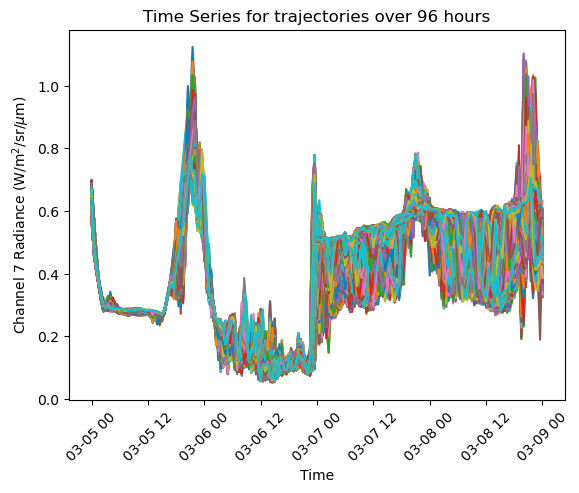

In [9]:
# Get the dimensions of the data array
n_time_steps, n_x, n_y = trajectories.shape

# Plot each point
for x in range(n_x):
    for y in range(n_y):
        plt.plot(times_plot,trajectories[:, x, y], label=f'Point ({x}, {y})')

plt.xlabel('Time')
plt.ylabel(f"Channel {channel} Radiance (W/m$^2$/sr/$\mu$m)")
plt.title(f'Time Series for trajectories over {time_advected} hours')
plt.xticks(rotation=45)
plt.show()

In [10]:
print(type(GOES_times_plot))

NameError: name 'GOES_times_plot' is not defined

ValueError: x and y must have same first dimension, but have shapes (48,) and (144,)

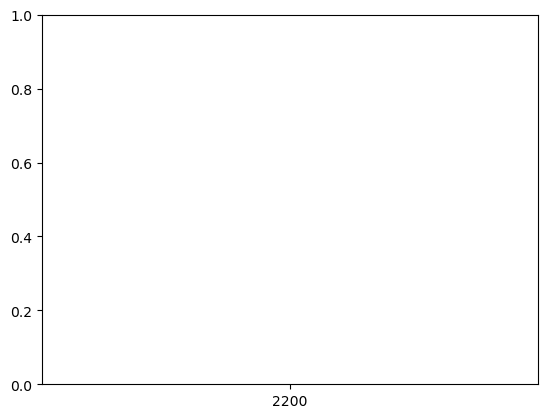

In [ ]:
# Assuming trajectories is your data array
# Get the dimensions of the data array
n_time_steps, n_x, n_y = trajectories.shape

# Plot each point
for x in range(n_time_steps-len(index_to_skip)):
    for y in range(n_y-len(index_to_skip)):
        plt.plot(GOES_times_plot, trajectories[:, x, y], label=f'Point ({x}, {y})')

plt.xlabel('Time')
plt.ylabel(f"Channel {channel} Radiance (W/m$^2$/sr/$\mu$m)")
plt.title('Time Series for All Points')
plt.xticks(rotation=90)
#plt.legend()
plt.show()

In [ ]:
print(GOES_times_plot)


['2200' '2230' '2300' '2330' '0000' '0030' '0100' '0130' '0200' '0230'
 '0300' '0330' '0400' '0430' '0500' '0530' '0600' '0630' '0700' '0730'
 '0800' '0830' '0900' '0930' '1000' '1030' '1100' '1130' '1200' '1230'
 '1300' '1330' '1400' '1430' '1500' '1530' '1600' '1630' '1700' '1730'
 '1800' '1830' '1900' '1930' '2030' '2100' '2130' '2200']


In [ ]:
GOES_times_masked = np.ma.masked_array(GOES_times, mask=np.isin(np.arange(len(GOES_times)), index_to_skip))



print(n_time_steps)

print(GOES_times_masked.shape)

print(GOES_times)

print(GOES_times_masked)

96
(97,)
['2200' '2230' '2300' '2330' '0000' '0030' '0100' '0130' '0200' '0230'
 '0300' '0330' '0400' '0430' '0500' '0530' '0600' '0630' '0700' '0730'
 '0800' '0830' '0900' '0930' '1000' '1030' '1100' '1130' '1200' '1230'
 '1300' '1330' '1400' '1430' '1500' '1530' '1600' '1630' '1700' '1730'
 '1800' '1830' '1900' '1930' '2000' '2030' '2100' '2130' '2200' '2230'
 '2300' '2330' '0000' '0030' '0100' '0130' '0200' '0230' '0300' '0330'
 '0400' '0430' '0500' '0530' '0600' '0630' '0700' '0730' '0800' '0830'
 '0900' '0930' '1000' '1030' '1100' '1130' '1200' '1230' '1300' '1330'
 '1400' '1430' '1500' '1530' '1600' '1630' '1700' '1730' '1800' '1830'
 '1900' '1930' '2000' '2030' '2100' '2130' '2200']
['2200' '2230' '2300' '2330' '0000' '0030' '0100' '0130' '0200' '0230'
 '0300' '0330' '0400' '0430' '0500' '0530' '0600' '0630' '0700' '0730'
 '0800' '0830' '0900' '0930' '1000' '1030' '1100' '1130' '1200' '1230'
 '1300' '1330' '1400' '1430' '1500' '1530' '1600' '1630' '1700' '1730'
 '1800' '1830' '1

In [ ]:
print(trajectories.shape)

(96, 20, 20)


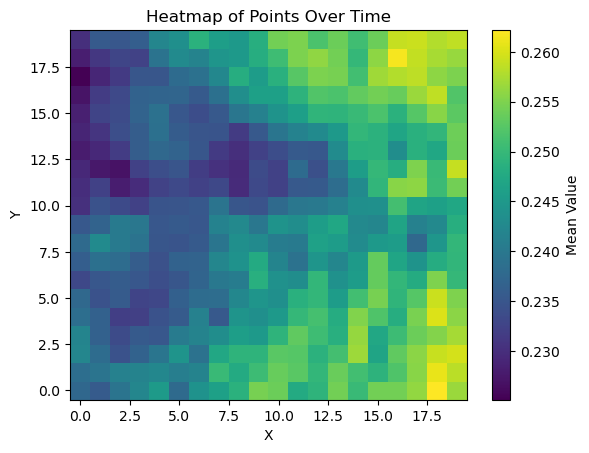

In [ ]:
import matplotlib.pyplot as plt

# Assuming trajectories is your data array
# Get the dimensions of the data array
n_time_steps, n_x, n_y = trajectories.shape

# Create a heatmap
plt.imshow(trajectories[:, :, :].mean(axis=0), cmap='viridis', origin='lower', aspect='auto')

# Add colorbar
plt.colorbar(label='Mean Value')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of Points Over Time')
plt.show()


In [ ]:
print(result_array.shape)d

SyntaxError: invalid syntax (2622755057.py, line 1)

In [ ]:
print(GI.shape)

(25, 2, 20, 20)


In [ ]:
GI = gran.locate(np.array([positions]), channel=channel)[0]

print(positions.shape)

print(GI.shape)

(25, 2, 20, 20)
(2, 2, 20, 20)


In [ ]:
positions = np.array(positions)
print(positions.shape)
print(n_steps)

(25, 2, 20, 20)
25


In [ ]:
test = positions[0,:,:,:]

print(test.shape)

print(test[:,0,0])

testing = test[:,0,0]

print(testing)

print(testing.shape)

testies = testing[:]

print(testies)

GI = gran.locate(np.array([testing]), channel=channel)

print(GI)

#print(GI)

(2, 20, 20)
[-140.70682982   39.64499557]
[-140.70682982   39.64499557]
(2,)
[-140.70682982   39.64499557]
[[1098  357]]


In [ ]:
GI = gran.locate(np.array([test]), channel=channel)[0]

print(GI.shape)

(2, 20, 20)


In [ ]:
GOES_index = gran.locate(test, channel=channel)

print(GOES_index)

[[[   1097    1098    1099    1100    1101    1102    1104    1105
      1106    1107    1108    1109    1110    1111    1112    1113
      1114    1115    1116    1117]
  [    370     369     368     367     366     365     364     364
       363     362     361     360     359     358     357     356
       355     354     354     353]]

 [[-999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999]
  [-999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999]]]


In [ ]:
#print(positions[:,:,0,0])

first_tstep = positions[0,:,:,:]

#print(first_tstep)

GOES_index = gran.locate(first_tstep, channel=channel)

print(GOES_index)

print(GOES_index.shape)

[[[   1097    1098    1099    1100    1101    1102    1104    1105
      1106    1107    1108    1109    1110    1111    1112    1113
      1114    1115    1116    1117]
  [    370     369     368     367     366     365     364     364
       363     362     361     360     359     358     357     356
       355     354     354     353]]

 [[-999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999]
  [-999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999 -999999 -999999 -999999 -999999
   -999999 -999999 -999999 -999999]]]
(2, 2, 20)


In [ ]:
# now read off corresponding GOES data for each position in space and time
# In general I will be using the GOES west CONUS data, this will need to be adapated if the lat/lon of the parcel falls off this region

region = []
central_latlon = np.zeros((n_steps, 2))
init_ll_index = np.zeros((n_steps, 2))

region_size = 150
image = np.zeros((n_steps, region_size, region_size))
threshold_bt = 273.15  # Set your threshold brightness temperature value here

for i in range(n_steps):
    gran = GOES.Granule.fromtext(f'G17.{year}{GOES_doy[i]}.{GOES_times[i]}.RadC')

    try:
        gran.get_filename(channel=channel)
    except IndexError:
        gran.download(channel=channel)
        print('downloading granule')

    try:
        GOES_index = gran.locate(positions[i,:,:,:], channel=channel)
    except IndexError as e:
        if 'No matching file' in str(e):
            print(f"Error: {e}. Skipping this time step.")
            continue
        else:
            raise

    data = gran.get_band_radiance(channel=channel)






In [ ]:
print(GOES_index.shape)

(2, 2, 20)


In [ ]:

    rad_trajectories = data[GOES_index[:, 0], GOES_index[:, 1]]

    lon_min = max(0, int(GOES_index[1] - region_size / 2))
    lon_max = min(data.shape[0], int(GOES_index[1] + region_size / 2))
    lat_min = max(0, int(GOES_index[0] - region_size / 2))
    lat_max = min(data.shape[1], int(GOES_index[0] + region_size / 2))

    lon1, lat1 = gran.get_lonlat(channel=channel)

    image[i] = data[lon_min:lon_max, lat_min:lat_max]
    central_latlon[i] = [lon1[GOES_index[1], GOES_index[0]], lat1[GOES_index[1], GOES_index[0]]]

In [ ]:
print(GOES_index.shape)
print(GOES_index)

(25, 2)
[[1098  357]
 [1097  360]
 [1095  364]
 [1093  367]
 [1091  370]
 [1090  374]
 [1087  378]
 [1085  381]
 [1082  385]
 [1079  388]
 [1076  391]
 [1072  394]
 [1068  397]
 [1065  399]
 [1061  401]
 [1057  403]
 [1054  404]
 [1050  405]
 [1047  406]
 [1044  407]
 [1041  408]
 [1038  408]
 [1035  408]
 [1033  408]
 [1030  408]]


In [ ]:
import numpy as np

# Assuming data is your matrix
data = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9]])

# Assuming GOES_index is an array of indices
GOES_index = np.array([[0, 1], [1, 2], [2, 0]])

# Create a third matrix using NumPy indexing
third_matrix = data[GOES_index[:, 0], GOES_index[:, 1]]

print(third_matrix)

print(GOES_index[:, 0], GOES_index[:, 1])


[2 6 7]
[0 1 2] [1 2 0]


In [ ]:
data = gran.get_product_data('L2-ACTP')
#data = gran.get_band_radiance(channel=7)
## add colourbar
plt.imshow(data)
bar = plt.colorbar()

plt.show()

import matplotlib.pyplot as plt

IndexError: No matching file

Exception ignored in: <function tqdm.__del__ at 0x7faa5d3a60d0>
Traceback (most recent call last):
  File "/home/gjp23/.conda/envs/py38_trklib/lib/python3.8/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/gjp23/.conda/envs/py38_trklib/lib/python3.8/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


KeyboardInterrupt: 

In [ ]:
print(lon.shape)

(1500, 2500)


In [ ]:
# Create an AdvectParcel object

for i in tqdm(range(10)):

    winddata = ECMWF.ERA5WindData(level="1000hPa",res="1grid",linear_interp="both") # wind data on 1 degree grid, linearly interpolated in space and time
    init_position = [lon, lat]
    parcel = trackerlib.AdvectParcel(winddata, init_position, init_time, time_step)


# Get the list of positions and winds
    positions, winds = parcel.advect(total_time) #[lon,lat]
positions = np.array(positions)
winds = np.array(winds)

lon = positions[:,0]
lat = positions[:,1]

    # Simulate some work
time.sleep(0.1)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
######### Double check the order of lon,lat for each line
GOES_index_app,bt_track,bt_track_mean,bt_track_std = [],np.zeros(n_steps),np.zeros(n_steps),np.zeros(n_steps) #initialize arrays

region_size = 10  # Size of the square region for the mean and variance calculation, suitable pixel size over which cloud would be ~homogeneous maybe something like 'points in radius' would be better due to stretching of pixels at edge

for i in range(n_steps):
    gran = GOES.Granule.fromtext(f'G16.{year}{GOES_doy[i]}.{GOES_times[i]}.RadF')  #fix this so that the year updates if the doy goes past 365 
    GOES_index = gran.locate(np.array([[lon[i],lat[i]]]), channel=13)[0] ##needs to be (lon,lat) format!
    bt = gran.get_band_bt(channel=13) ######This step takes all the time, takes about 30 seconds for 12 data points, not much to be gained from vectorizing other operations

    # Calculate the limits of the square region, checking that we are not falling off the edge of the swath
    lat_min = max(0, int(GOES_index[0] - region_size / 2))
    lat_max = min(bt.shape[0], int(GOES_index[0] + region_size / 2))
    lon_min = max(0, int(GOES_index[1] - region_size / 2))
    lon_max = min(bt.shape[1], int(GOES_index[1] + region_size / 2))

    # Extract the square region and calculate the mean and variance
    region = bt[lat_min:lat_max, lon_min:lon_max]
    mean_value = np.mean(region)
    variance_value = np.var(region)

    # Update the bt_track array
    bt_track_mean[i] = mean_value
    bt_track_std[i] = np.sqrt(variance_value)/region_size #divide by number of pixels to get std for the mean

IndexError: No matching file

<class 'xarray.core.dataarray.DataArray'>


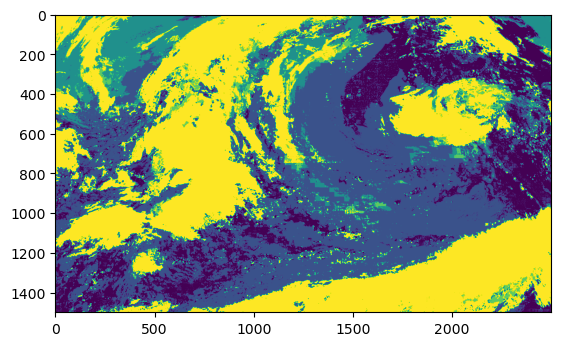

In [ ]:
from csat2 import GOES
gran = GOES.Granule.fromtext('G17.2020100.1730.RadC')
data = gran.get_product_data('L2-ACTP')
#data = gran.get_band_radiance(channel=7)

import matplotlib.pyplot as plt
plt.imshow(data)

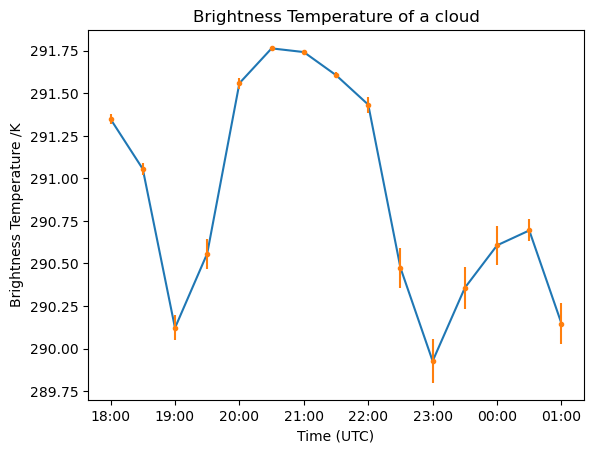

In [ ]:
plt.plot(times,bt_track_mean)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.errorbar(times, bt_track_mean, yerr=bt_track_std, fmt='o', markersize=3, label='Brightness Temperature')
plt.xlabel('Time (UTC)')
plt.ylabel('Brightness Temperature /K')
plt.title('Brightness Temperature of a cloud')
plt.show()

In [ ]:
print(bt)

<xarray.DataArray (y: 5424, x: 5424)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    t        datetime64[ns] 2018-07-13T01:06:03.549328
    y_image  float32 0.0
    x_image  float32 0.0
  * y        (y) float64 0.1518 0.1518 0.1517 0.1517 ... -0.1517 -0.1518 -0.1518
  * x        (x) float64 -0.1518 -0.1518 -0.1517 ... 0.1517 0.1518 0.1518


In [ ]:
GOES_index_app,bt_track,bt_track_mean,bt_track_std,bt = [],np.zeros(n_steps),np.zeros(n_steps),np.zeros(n_steps),[]#initialize arrays

region_size = 10  # Size of the square region for the mean and variance calculation, suitable pixel size over which cloud would be ~homogeneous maybe something like 'points in radius' would be better due to stretching of pixels at edge


for i in range(n_steps):
    gran = GOES.Granule.fromtext(f'G16.{year}{doy}.{GOES_times[i]}.RadF')  #fic this so that the day of the year updates if the day changes  ###(f'G16.{year}{doy}.{GOES_times[i]}.CODF')
    GOES_index_app.append(np.array(gran.locate(np.array([[lon[i], lat[i]]]), channel=13)[0])) ##needs to be (lon,lat) format!
    bt.append(gran.get_band_bt(channel=13))

print(np.array(GOES_index_app).shape)

print(GOES_index_app[0][0])

GOES_index_app = np.array(GOES_index_app)

(15, 2)
2711


In [ ]:
mlocs = GOES_index_app[:, None, None, :].repeat(10, axis=1).repeat(10, axis=2)

mlocs[:, :, :, 0] += np.arange(-5, 5)[None,:, None] 
mlocs[:, :, :, 1] += np.arange(-5, 5)[None, None, :]

plt.plot(bt.data[mlocs[:, :, :, 0], mlocs[:, :, :, 1]].mean(axis=(1,2)))

print(mlocs.shape)

print(mlocs)

AttributeError: 'list' object has no attribute 'data'

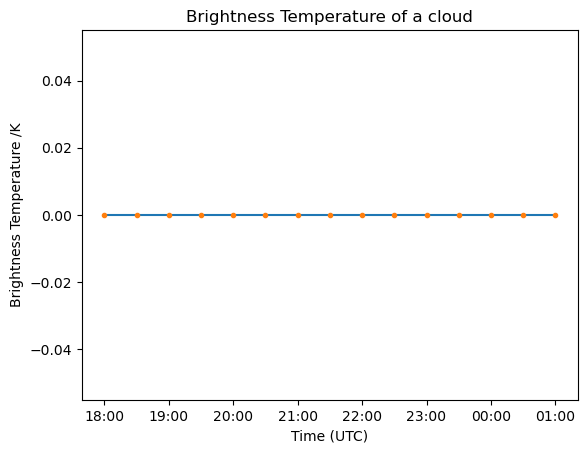

In [ ]:
plt.plot(times,bt_track_mean)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.errorbar(times, bt_track_mean, yerr=bt_track_std, fmt='o', markersize=3, label='Brightness Temperature')
plt.xlabel('Time (UTC)')
plt.ylabel('Brightness Temperature /K')
plt.title('Brightness Temperature of a cloud')
plt.show()

In [ ]:
##vectorize loop

gran = GOES.Granule.fromtext(f'G16.{year}{doy}.{GOES_times[0]}.RadF')

mlocs = (gran.locate(np.array([[lon, lat]]), channel=13)[0])[:, None, None, :].repeat(10, axis=1).repeat(10, axis=2)

mlocs[:, :, :, 0] += np.arange(-5, 5)[None,:, None] 
mlocs[:, :, :, 1] += np.arange(-5, 5)[None, None, :]

#plt.plot(bt.data[mlocs[:, :, :, 0], mlocs[:, :, :, 1]].mean(axis=(1,2)))
#plt.show()

print(mlocs)

[[[[2706 2706 2711 ... 2703 2702 2701]
   [2706 2707 2711 ... 2703 2702 2701]
   [2706 2708 2711 ... 2703 2702 2701]
   ...
   [2706 2713 2711 ... 2703 2702 2701]
   [2706 2714 2711 ... 2703 2702 2701]
   [2706 2715 2711 ... 2703 2702 2701]]

  [[2707 2706 2711 ... 2703 2702 2701]
   [2707 2707 2711 ... 2703 2702 2701]
   [2707 2708 2711 ... 2703 2702 2701]
   ...
   [2707 2713 2711 ... 2703 2702 2701]
   [2707 2714 2711 ... 2703 2702 2701]
   [2707 2715 2711 ... 2703 2702 2701]]

  [[2708 2706 2711 ... 2703 2702 2701]
   [2708 2707 2711 ... 2703 2702 2701]
   [2708 2708 2711 ... 2703 2702 2701]
   ...
   [2708 2713 2711 ... 2703 2702 2701]
   [2708 2714 2711 ... 2703 2702 2701]
   [2708 2715 2711 ... 2703 2702 2701]]

  ...

  [[2713 2706 2711 ... 2703 2702 2701]
   [2713 2707 2711 ... 2703 2702 2701]
   [2713 2708 2711 ... 2703 2702 2701]
   ...
   [2713 2713 2711 ... 2703 2702 2701]
   [2713 2714 2711 ... 2703 2702 2701]
   [2713 2715 2711 ... 2703 2702 2701]]

  [[2714 2706 2711 ..

In [ ]:
print(mlocs[:,0,0,:])

[[2706 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [ 724  724  730  730  730  730  730  730  730  730  730  730  729]]


In [ ]:
print(mlocs[0,:,0,:])

[[2706 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2707 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2708 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2709 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2710 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2711 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2712 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2713 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2714 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]
 [2715 2706 2711 2710 2709 2708 2708 2707 2706 2704 2703 2702 2701]]


In [ ]:
print(mlocs.shape)

(2, 10, 10, 13)


In [ ]:
gran = GOES.Granule.fromtext(f'G16.{year}{doy}.{1200}.RadF')

COD = gran.get_filename(product = 'COD')

KeyError: 'COD'